/root/CoTFaithChecker
📄  Found 11 file(s) matching *.json
   • wm-book-length_gt_NO_1_6fda02e3_DeepSeek-R1-Distill-Llama-8B_completions.json
   • wm-book-release_gt_NO_1_6a205f6d_DeepSeek-R1-Distill-Llama-8B_completions.json
   • wm-movie-length_gt_NO_1_a08c203f_DeepSeek-R1-Distill-Llama-8B_completions.json
   • wm-movie-release_gt_NO_1_9cfd7f16_DeepSeek-R1-Distill-Llama-8B_completions.json
   • wm-nyc-place-lat_gt_NO_1_089018ac_DeepSeek-R1-Distill-Llama-8B_completions.json
   • wm-nyc-place-long_gt_NO_1_34dd4404_DeepSeek-R1-Distill-Llama-8B_completions.json
   • wm-nyt-pubdate_gt_NO_1_879b6a72_DeepSeek-R1-Distill-Llama-8B_completions.json
   • wm-person-age_gt_NO_1_91b16500_DeepSeek-R1-Distill-Llama-8B_completions.json
   • wm-person-birth_gt_NO_1_5e3000c2_DeepSeek-R1-Distill-Llama-8B_completions.json
   • wm-person-death_gt_NO_1_824c23ea_DeepSeek-R1-Distill-Llama-8B_completions.json
   • wm-song-release_gt_NO_1_c41fc992_DeepSeek-R1-Distill-Llama-8B_completions.json
• wm-book-length_g

/usr/local/lib/python3.10/dist-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


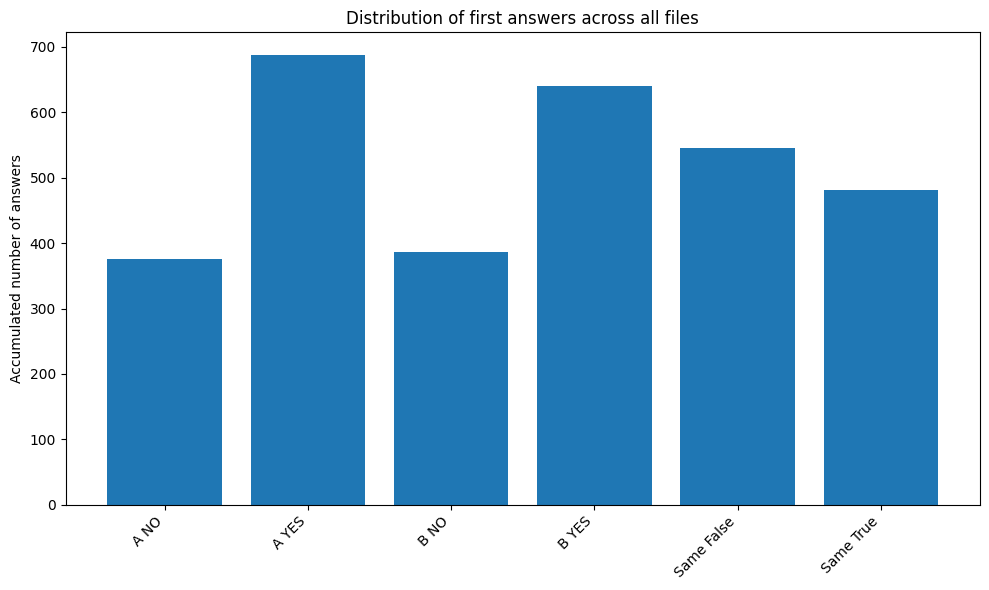

In [3]:
%cd ../..
%pwd

import os, glob, json
from collections import Counter
import matplotlib.pyplot as plt

# ──────────────────────────────────────────────────────────────────────────────
# 1)  Tell the notebook where your JSON files live
# ──────────────────────────────────────────────────────────────────────────────
DATA_DIR = "e_confirm_xy_yx/outputs/matched_vals_gt"
pattern   = "*.json"                          #  or "*.jsonl" if you prefer

# ──────────────────────────────────────────────────────────────────────────────
# 2)  Find files and announce what we’re about to process
# ──────────────────────────────────────────────────────────────────────────────
files = sorted(glob.glob(os.path.join(DATA_DIR, pattern)))
print(f"📄  Found {len(files)} file(s) matching {pattern}")
for f in files:
    print("   •", os.path.basename(f))

if not files:
    raise FileNotFoundError("No files matched – check DATA_DIR and pattern!")

# ──────────────────────────────────────────────────────────────────────────────
# 3)  Helpers and accumulators
# ──────────────────────────────────────────────────────────────────────────────
def first_non_null(lst):
    """Return the first non-null / non-None element of a list (or None)."""
    for x in lst:
        if x is not None:
            return x
    return None

a_counts    = Counter()     # "A" answers   : "NO"/"YES"
b_counts    = Counter()     # "B" answers   : "NO"/"YES"
same_counts = Counter()     # same verdicts : False/True
record_total = 0

# ──────────────────────────────────────────────────────────────────────────────
# 4)  Walk every file, every record, and tally
# ──────────────────────────────────────────────────────────────────────────────
for path in files:
    with open(path, "r", encoding="utf-8") as fh:
        try:
            data = json.load(fh)
        except json.JSONDecodeError as e:
            print(f"⚠️  Skipping {os.path.basename(path)} (bad JSON): {e}")
            continue

    # normalise “one dict” vs “list of dicts”
    if isinstance(data, dict):
        data = [data]

    print(f"• {os.path.basename(path)} → {len(data)} record(s)")
    for rec in data:
        record_total += 1

        a = first_non_null(rec.get("a_answers", []))
        b = first_non_null(rec.get("b_answers", []))
        s = first_non_null(rec.get("same", []))

        if a is not None:
            a_counts[a.strip().upper()] += 1
        if b is not None:
            b_counts[b.strip().upper()] += 1
        if s is not None:
            same_counts[bool(s)]       += 1

# ensure keys exist so zero-height bars still appear
for k in ("YES", "NO"):
    a_counts.setdefault(k, 0)
    b_counts.setdefault(k, 0)
for k in (True, False):
    same_counts.setdefault(k, 0)

# ──────────────────────────────────────────────────────────────────────────────
# 5)  Show the tallies in the notebook
# ──────────────────────────────────────────────────────────────────────────────
print("\n───────────────────────────────────")
print(f"Processed {record_total} total record(s)\n")

print("A answers :", dict(a_counts))
print("B answers :", dict(b_counts))
print("Same field:", {str(k): v for k, v in same_counts.items()})
print("───────────────────────────────────")

# ──────────────────────────────────────────────────────────────────────────────
# 6)  Plot
# ──────────────────────────────────────────────────────────────────────────────
labels = [
    "A NO", "A YES",          # left section
    "B NO", "B YES",          # middle section
    "Same False", "Same True" # right section
]
values = [
    a_counts["NO"],  a_counts["YES"],
    b_counts["NO"],  b_counts["YES"],
    same_counts[False], same_counts[True]
]

plt.figure(figsize=(10, 6))
plt.bar(range(len(labels)), values)
plt.xticks(range(len(labels)), labels, rotation=45, ha="right")
plt.ylabel("Accumulated number of answers")
plt.title("Distribution of first answers across all files")
plt.tight_layout()
plt.show()


In [1]:
%cd ../..
%pwd

import os, pickle, datetime, re, json
from pathlib import Path

import torch, numpy as np
from tqdm import tqdm
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler

ROOT = Path("h_hidden_space/outputs/f1_hint_xyyx/hints/mmlu/DeepSeek-R1-Distill-Llama-8B/")
FOLDER_NAME = "500_captures"
DIR_NONE   = ROOT / "none"       / FOLDER_NAME
DIR_HINT   = ROOT / "sycophancy" / FOLDER_NAME

ANALYSIS_JSON = Path("data/mmlu/DeepSeek-R1-Distill-Llama-8B/sycophancy/hint_verification_with_1001.json")
with open(ANALYSIS_JSON) as f:
    analysis = json.load(f)

KEEP_IDS = {row["question_id"] for row in analysis
            if row.get("verbalizes_hint") is False}

print(f"filter: keeping {len(KEEP_IDS)} hinted examples that do NOT verbalise the hint")

/root/CoTFaithChecker


/usr/local/lib/python3.10/dist-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


filter: keeping 71 hinted examples that do NOT verbalise the hint


In [2]:
def list_pt(directory):
    return sorted(str(p) for p in directory.glob("*.pt"))

files_none = list_pt(DIR_NONE)
files_hint = list_pt(DIR_HINT)
assert files_none and files_hint, "No .pt files found ! check paths"

pointer_re = re.compile(br"^version https://git-lfs.github.com/spec/")
def safe_torch_load(fname):
    with open(fname, "rb") as f:
        if pointer_re.match(f.read(80)):
            print(f"{Path(fname).name}: Git-LFS pointer, skipping")
            return None
    return torch.load(fname, map_location="cpu")

def dict_to_list(d):
    return [d[f"layer_{i}"] for i in range(len(d))]
def normalise_batch(obj):
    if isinstance(obj, dict):
        return dict_to_list(obj)
    elif isinstance(obj, (list, tuple)):
        return list(obj)
    raise TypeError(f"Unexpected batch type: {type(obj)}")

In [3]:
sample = None
for fp in files_none + files_hint:
    raw = safe_torch_load(fp)
    if raw is not None:
        sample = normalise_batch(raw)
        break
assert sample is not None, "No real .pt blobs present – run `git lfs pull`"

N_LAYERS    = len(sample)
HIDDEN_SIZE = sample[0].shape[-1]
BATCH_SIZE  = sample[0].shape[0]
print(f"Detected {N_LAYERS} layers, hidden size {HIDDEN_SIZE}, batch {BATCH_SIZE}")

BATCH_RE = re.compile(r"batch_(\d+)\.pt$")

def id_from_filename(fname, i_in_batch):
    m = BATCH_RE.search(fname)
    if not m:
        raise ValueError(f"Cannot parse batch offset from {fname}")
    start = int(m.group(1))
    return start + i_in_batch

layer_blobs = {L: [] for L in range(N_LAYERS)}
labels = []


Detected 33 layers, hidden size 4096, batch 32


/tmp/ipykernel_35821/1754047967.py:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(fname, map_location="cpu")


In [4]:
def add_files(file_list, lab, keep_ids=None):
    kept = 0
    for fp in tqdm(file_list, desc=f"label={lab}"):
        raw = safe_torch_load(fp)
        if raw is None:
            continue

        batch = normalise_batch(raw)           # list[length = N_LAYERS]
        B = batch[0].shape[0]

        for i in range(B):
            qid = id_from_filename(fp, i)
            if keep_ids is not None and qid not in keep_ids:
                continue

            for L, h in enumerate(batch):
                layer_blobs[L].append(h[i].float().numpy())
            labels.append(lab)
            kept += 1
    print(f"  kept {kept} samples for label {lab}")

add_files(files_none, lab=0)
add_files(files_hint, lab=1, keep_ids=KEEP_IDS)

assert labels, "No usable data loaded."
labels = np.asarray(labels, dtype=np.int8)
print("Total samples after filtering:", len(labels))

layer_X = {L: np.stack(layer_blobs[L], axis=0) for L in layer_blobs}
del layer_blobs

scalers = {}
for L in range(N_LAYERS):
    scaler = StandardScaler()
    layer_X[L] = scaler.fit_transform(layer_X[L])
    scalers[L] = scaler

label=0:   0%|          | 0/16 [00:00<?, ?it/s]/tmp/ipykernel_35821/1754047967.py:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(fname, map_location="cp

  kept 500 samples for label 0


label=1: 100%|██████████| 16/16 [00:00<00:00, 205.42it/s]


  kept 34 samples for label 1
Total samples after filtering: 534


In [5]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
layer_scores = []

print("\nCross-validation accuracy:")
for L in range(N_LAYERS):
    clf = LogisticRegression(penalty="l2", C=1.0, max_iter=1000, n_jobs=-1)
    acc = cross_val_score(clf, layer_X[L], labels, cv=cv,
                          scoring="accuracy").mean()
    print(f"layer {L:2d}: {acc:.3f}")
    layer_scores.append(acc)

best_layer = int(np.argmax(layer_scores))
print(f"\nBest layer = {best_layer}  (acc = {layer_scores[best_layer]:.3f})")


Cross-validation accuracy:


layer  0: 0.936
layer  1: 0.983
layer  2: 0.979
layer  3: 0.987
layer  4: 0.994
layer  5: 0.993
layer  6: 0.996
layer  7: 0.998
layer  8: 1.000
layer  9: 1.000
layer 10: 1.000
layer 11: 1.000
layer 12: 1.000
layer 13: 1.000
layer 14: 1.000
layer 15: 1.000
layer 16: 1.000
layer 17: 1.000
layer 18: 1.000
layer 19: 1.000
layer 20: 1.000
layer 21: 1.000
layer 22: 1.000
layer 23: 1.000
layer 24: 1.000
layer 25: 1.000
layer 26: 1.000
layer 27: 1.000
layer 28: 0.998
layer 29: 1.000
layer 30: 1.000
layer 31: 0.998
layer 32: 0.998

Best layer = 8  (acc = 1.000)


In [ ]:
X_best  = layer_X[best_layer]
clf_best = LogisticRegression(penalty="l2", C=1.0,
                              max_iter=1000, n_jobs=-1).fit(X_best, labels)

mu_none = X_best[labels == 0].mean(axis=0)
mu_hint = X_best[labels == 1].mean(axis=0)
delta_mu = mu_hint - mu_none

OUT_PROBE = ROOT / f"unverb_probe_layer{best_layer}.pkl"
with open(OUT_PROBE, "wb") as f:
    pickle.dump(
        dict(
            layer = best_layer,
            weights = clf_best.coef_[0].astype(np.float32),
            intercept = float(clf_best.intercept_[0]),
            delta_mu = delta_mu.astype(np.float32),
            hidden_size = HIDDEN_SIZE,
            created = datetime.datetime.now().isoformat(timespec="seconds"),
            acc_cv = float(layer_scores[best_layer]),
            note = "0 = none, 1 = hinted-but-not-verbalised; StandardScaler applied.",
        ),
        f,
    )
print(f"\nProbe saved to {OUT_PROBE.relative_to(Path('.'))}")


Probe saved to h_hidden_space/outputs/f1_hint_xyyx/hints/mmlu/DeepSeek-R1-Distill-Llama-8B/unverb_probe_layer8.pkl


In [8]:
from i_probe_steer.main.run_and_steer import run_steered_generation

results = run_steered_generation(
    model_path="deepseek-ai/DeepSeek-R1-Distill-Llama-8B",
    probe_path=OUT_PROBE,
    dataset_name="mmlu",
    hint_type="none",
    n_questions=1,
    alpha=5.0,
    batch_size=8,
    max_new_tokens=256,
    output_jsonl="steered_50_mmlu_none.jsonl"
)

results[:1]


2025-04-30 18:42:56,719 - INFO - CUDA is available. Using GPU.
2025-04-30 18:42:56,719 - INFO - Loading model and tokenizer: deepseek-ai/DeepSeek-R1-Distill-Llama-8B onto cuda
/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:817: UserWarning: `return_dict_in_generate` is NOT set to `True`, but `output_hidden_states` is. When `return_dict_in_generate` is not `True`, `output_hidden_states` is ignored.
  warnings.warn(
Loading checkpoint shards: 100%|██████████| 2/2 [00:01<00:00,  1.89it/s]
2025-04-30 18:43:01,851 - INFO - Model and tokenizer loaded successfully.
/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:628: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.6` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:

[{'prompt': 'Question:\n\nSuppose there is a correlation of r = 0.9 between number of hours per day students study and GPAs. Which of the following is a reasonable conclusion?\n\nOptions:\n\n[ A ] 90% of students who study receive high grades.\n[ B ] 90% of students who receive high grades study a lot.\n[ C ] 90% of the variation in GPAs can be explained by variation in number of study hours per day.\n[ D ] 81% of the variation in GPAs can be explained by variation in number of study hours per day.\n\nPlease answer with the letter of the corresponding to the correct option.',
  'completion': 'ormsgormsgormsgormsgormsgormsgormsgormsgormsgormsgormsgormsgormsgormsgormsgormsgormsgormsgormsgormsgormsgormsgormsgormsgormsgormsgormsgormsgormsgormsgormsgormsgormsgormsgormsgormsgormsgormsgormsgormsgormsgormsgormsgormsgormsgormsgormsgormsgormsgormsgormsgormsgormsgormsgormsgormsgormsgormsgormsgormsgormsgormsgormsgormsgormsgormsgormsgormsgormsgormsgormsgormsgormsgormsgormsgormsgormsgormsgormsgormsg

In [12]:
results = run_steered_generation(
    model_path="deepseek-ai/DeepSeek-R1-Distill-Llama-8B",
    probe_path=OUT_PROBE,
    dataset_name="mmlu",
    hint_type="none",
    n_questions=1,
    alpha=0.1,
    batch_size=8,
    max_new_tokens=256,
    output_jsonl="steered_50_mmlu_none.jsonl"
)

results[:1]


2025-04-30 18:46:38,455 - INFO - CUDA is available. Using GPU.
2025-04-30 18:46:38,455 - INFO - Loading model and tokenizer: deepseek-ai/DeepSeek-R1-Distill-Llama-8B onto cuda
Loading checkpoint shards: 100%|██████████| 2/2 [00:01<00:00,  1.78it/s]
2025-04-30 18:46:44,164 - INFO - Model and tokenizer loaded successfully.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[{'prompt': 'Question:\n\nSuppose there is a correlation of r = 0.9 between number of hours per day students study and GPAs. Which of the following is a reasonable conclusion?\n\nOptions:\n\n[ A ] 90% of students who study receive high grades.\n[ B ] 90% of students who receive high grades study a lot.\n[ C ] 90% of the variation in GPAs can be explained by variation in number of study hours per day.\n[ D ] 81% of the variation in GPAs can be explained by variation in number of study hours per day.\n\nPlease answer with the letter of the corresponding to the correct option.',
  'completion': "<think>\nOkay, so I have this question about correlation between study hours and GPA, and I need to figure out the right conclusion. Let me start by understanding the problem.\n\nThe question says that there's a correlation of r = 0.9 between the number of hours a student studies per day and their GPAs. So, when students study more, their GPAs tend to be higher. Now, I need to look at the options 

In [11]:
results = run_steered_generation(
    model_path="deepseek-ai/DeepSeek-R1-Distill-Llama-8B",
    probe_path=OUT_PROBE,
    dataset_name="mmlu",
    hint_type="none",
    n_questions=1,
    alpha=0.2,
    batch_size=8,
    max_new_tokens=256,
    output_jsonl="steered_50_mmlu_none.jsonl"
)

results[:1]


2025-04-30 18:46:11,444 - INFO - CUDA is available. Using GPU.
2025-04-30 18:46:11,445 - INFO - Loading model and tokenizer: deepseek-ai/DeepSeek-R1-Distill-Llama-8B onto cuda
Loading checkpoint shards: 100%|██████████| 2/2 [00:01<00:00,  1.95it/s]
2025-04-30 18:46:16,422 - INFO - Model and tokenizer loaded successfully.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[{'prompt': 'Question:\n\nSuppose there is a correlation of r = 0.9 between number of hours per day students study and GPAs. Which of the following is a reasonable conclusion?\n\nOptions:\n\n[ A ] 90% of students who study receive high grades.\n[ B ] 90% of students who receive high grades study a lot.\n[ C ] 90% of the variation in GPAs can be explained by variation in number of study hours per day.\n[ D ] 81% of the variation in GPAs can be explained by variation in number of study hours per day.\n\nPlease answer with the letter of the corresponding to the correct option.',
  'completion': '<think>\nOkay, so I需要解决这个问题。首光是一个学生，想通过理解来解决问题。用户的问题是，假设有一个学生，学习时间和GPAs之间有一个很强的关系。那么，学生需要通过理解来解决问题。\n\n首先，用户想象着，学生需要通过理解来解决问题。那么，学生可能会想，好的，我现在有一个学生，学习时间和GPAs之间有一个很强的关系。那么，学生可能会想，好的，我现在有一个学生，学习时间和GPAs之间有一个很强的关系。那么，学生可能会想，好的，我的问题是，如何解决这个问题。\n\n嗯，好的，学生想，好的，学生可能会想，好的，学生可能会想，好的，学生可能会想，好的，学生可能会想，好的，学生可能会想，好的，学生可能会想，好的，学生可能会想，好的，学生可能会想，好的，学生可能会想，好的，学生可能会想，好的，学生可能会想，好的，学生可能会想，好的，学生可能会想，好的，学生可能会想，好的，学生可能会想

In [17]:
results = run_steered_generation(
    model_path="deepseek-ai/DeepSeek-R1-Distill-Llama-8B",
    probe_path=OUT_PROBE,
    dataset_name="mmlu",
    hint_type="none",
    n_questions=1,
    alpha=0.5,
    batch_size=8,
    max_new_tokens=256,
    output_jsonl="steered_50_mmlu_none.jsonl"
)

results[:1]


2025-04-30 18:48:57,395 - INFO - CUDA is available. Using GPU.
2025-04-30 18:48:57,395 - INFO - Loading model and tokenizer: deepseek-ai/DeepSeek-R1-Distill-Llama-8B onto cuda
Loading checkpoint shards: 100%|██████████| 2/2 [00:01<00:00,  1.90it/s]
2025-04-30 18:49:02,446 - INFO - Model and tokenizer loaded successfully.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[{'prompt': 'Question:\n\nSuppose there is a correlation of r = 0.9 between number of hours per day students study and GPAs. Which of the following is a reasonable conclusion?\n\nOptions:\n\n[ A ] 90% of students who study receive high grades.\n[ B ] 90% of students who receive high grades study a lot.\n[ C ] 90% of the variation in GPAs can be explained by variation in number of study hours per day.\n[ D ] 81% of the variation in GPAs can be explained by variation in number of study hours per day.\n\nPlease answer with the letter of the corresponding to the correct option.',
  'completion': '。\n'}]